In [1]:
from ellipsx import calc_psi_delta_one_layer_vec, calc_psi_delta_three_layers_vec

In [2]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

In [3]:
import jax
import numpy as np
import jax.numpy as jnp

In [4]:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

In [5]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True

In [8]:
%matplotlib inline

In [9]:
import optimistix as optx

In [10]:
from jaxtyping import Array, Complex, Float

# Подготовка данных

In [336]:
n_sub = 3.882 - 0.019j
n_f = 1.462 - 0j
d_f = 400
d_0f = 5
d_fs = 5

In [337]:
phi = jnp.linspace(30, 80, 6)

In [338]:
psi, delta = calc_psi_delta_one_layer_vec(phi, n_f, d_f, n_sub)
psi_3l, delta_3l = calc_psi_delta_three_layers_vec(phi, n_f, d_f, n_sub, d_0f, d_fs)

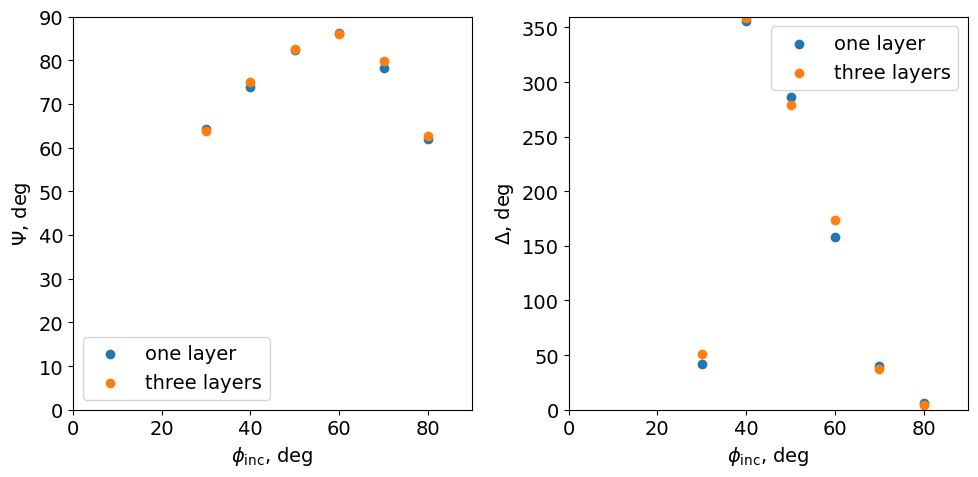

In [339]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(phi, psi, label='one layer')
ax1.scatter(phi, psi_3l, label='three layers')
ax2.scatter(phi, delta, label='one layer')
ax2.scatter(phi, delta_3l, label='three layers')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [340]:
from jax import random
key = random.key(20250811)
psi_std = 0.1
delta_std = 0.5

## One layer model

In [341]:
psi1 = psi + psi_std * random.normal(key, shape=psi.shape)
psi1_std = jnp.ones_like(psi1) * psi_std

In [342]:
delta1 = delta + delta_std * random.normal(key, shape=delta.shape)
delta1_std = jnp.ones_like(delta1) * delta_std

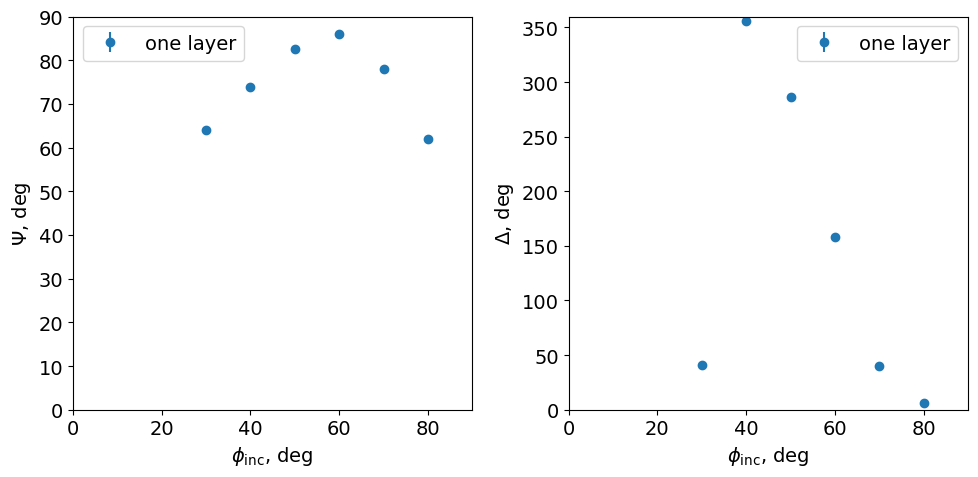

In [343]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='one layer', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='one layer', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [367]:
# Variable parameters are 1) oxide film thickness d_f, and 2) oxide refractive index n_f
# Other model parameters are fixed
@jax.jit
def residuals(params: Float[Array, "2"],
              args: tuple[Float[Array, "5 len"],
                          Float[Array, "2"],
                          Float,
                          Float]) -> Float[Array, "len + len"]:
    d_f = params[0]
    n_f = params[1] + 0j
    
    phi_psi_delta, n_sub_, n0, wl = args
    
    phi = phi_psi_delta[0]
    psi_obs = phi_psi_delta[1]
    psi_std = phi_psi_delta[2]
    delta_obs = phi_psi_delta[3]
    delta_std = phi_psi_delta[4]

    n_sub = n_sub_[0] + 1j * n_sub_[1]
    
    psi, delta = calc_psi_delta_one_layer_vec(phi, n_f, d_f, n_sub, n0, wl)
    return jnp.concatenate([(psi - psi_obs)/psi_std,
                           (delta - delta_obs)/delta_std])
    

In [368]:
params = jnp.array([400, 1.46])

In [369]:
args = (jnp.stack([phi, psi1, psi1_std, delta1, delta1_std]),
        jnp.array([3.882, - 0.019]),
        1.0,
        632.8)

In [370]:
args

(Array([[3.00000000e+01, 4.00000000e+01, 5.00000000e+01, 6.00000000e+01,
         7.00000000e+01, 8.00000000e+01],
        [6.41322795e+01, 7.38336875e+01, 8.24693695e+01, 8.61084714e+01,
         7.80867034e+01, 6.19536725e+01],
        [1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
         1.00000000e-01, 1.00000000e-01],
        [4.11526072e+01, 3.55736767e+02, 2.86338389e+02, 1.57691604e+02,
         3.95940685e+01, 6.40731014e+00],
        [5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
         5.00000000e-01, 5.00000000e-01]], dtype=float64),
 Array([ 3.882, -0.019], dtype=float64),
 1.0,
 632.8)

In [371]:
residuals(params, args)

Array([  4.42211696,   3.92048131,   1.65161435,  -0.10491332,
        -3.65236955,  -3.96113762,  -2.528718  ,  -3.7350164 ,
        -7.42740982, -11.04551548,  -2.23022421,  -1.72641449],      dtype=float64)

In [372]:
solver = optx.LevenbergMarquardt(rtol=1e-8, atol=1e-8)

In [373]:
sol = optx.least_squares(residuals, solver, params, args, max_steps=1024)

In [374]:
sol.value

Array([400.41937767,   1.46081055], dtype=float64)

In [375]:
phi_model = jnp.linspace(0, 90, 100)

In [376]:
psi, delta = calc_psi_delta_one_layer_vec(phi_model, sol.value[1], sol.value[0], 3.882 - 1j * 0.019)


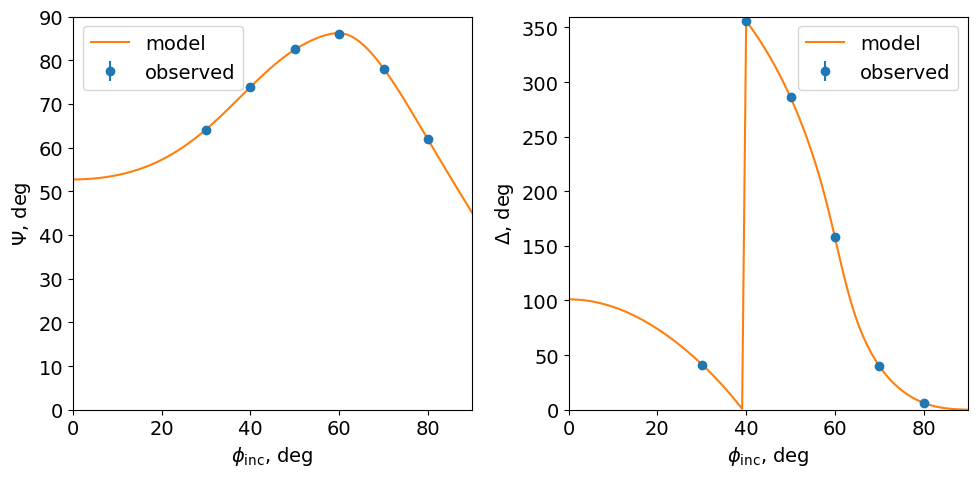

In [377]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [378]:
jac_res = jax.jacobian(residuals)(sol.value, args)

In [379]:
cov_matrix = jnp.linalg.inv(jac_res.T @ jac_res)

In [380]:
print(cov_matrix)

[[ 1.49166879e-01 -3.70876146e-04]
 [-3.70876146e-04  9.34853061e-07]]


In [381]:
std_params = jnp.sqrt(jnp.diag(cov_matrix))

In [382]:
sol.value, std_params

(Array([400.41937767,   1.46081055], dtype=float64),
 Array([0.38622128, 0.00096688], dtype=float64))

In [383]:
outer_v = np.outer(std_params, std_params)

In [384]:
cor_matrix = cov_matrix/outer_v

In [385]:
cor_matrix

Array([[ 1.        , -0.99316412],
       [-0.99316412,  1.        ]], dtype=float64)

## Three layer model

In [386]:
psi3 = psi_3l + psi_std * random.normal(key, shape=psi_3l.shape)
psi3_std = jnp.ones_like(psi_3l) * psi_std

In [387]:
delta3 = delta_3l + delta_std * random.normal(key, shape=delta_3l.shape)
delta3_std = jnp.ones_like(delta_3l) * delta_std

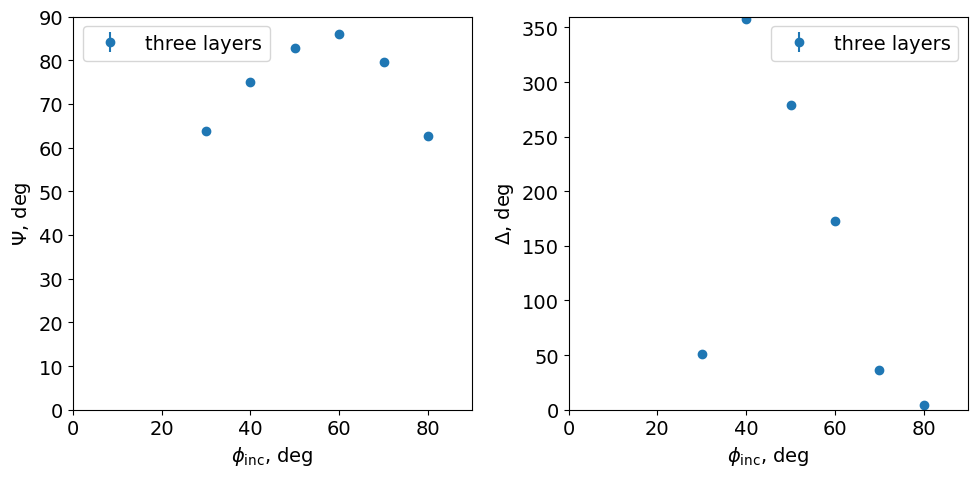

In [388]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='three layers', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='three layers', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [402]:
# Variable parameters are 1) oxide film thickness d_f, 2) oxide refractive index n_f,
# 3) interface width between air and oxide film d_0f, and 4) interface width between oxide film
# and substrate d_fs
# Other model parameters are fixed
@jax.jit
def residuals(params: Float[Array, "4"],
              args: tuple[Float[Array, "5 len"],
                          Float[Array, "2"],
                          Float,
                          Float]) -> Float[Array, "len + len"]:
    d_f = params[0]
    n_f = params[1] + 0j
    d_0f = params[2]
    d_fs = params[3]
    
    phi_psi_delta, n_sub_, n0, wl = args
    
    phi = phi_psi_delta[0]
    psi_obs = phi_psi_delta[1]
    psi_std = phi_psi_delta[2]
    delta_obs = phi_psi_delta[3]
    delta_std = phi_psi_delta[4]

    n_sub = n_sub_[0] + 1j * n_sub_[1]
    
    psi, delta = calc_psi_delta_three_layers_vec(phi, n_f, d_f, n_sub, d_0f, d_fs, n0, wl)
    return jnp.concatenate([(psi - psi_obs)/psi_std,
                           (delta - delta_obs)/delta_std])
    

In [427]:
params = jnp.array([400, 1.46, 4, 4])

In [428]:
args = (jnp.stack([phi, psi3, psi3_std, delta3, delta3_std]),
        jnp.array([3.882, - 0.019]),
        1.0,
        632.8)

In [429]:
residuals(params, args)

Array([  5.53062915,   1.21952926,   1.39486291,   1.9886115 ,
        -7.87481461,  -6.20963047,  -6.47970966,  -4.32858912,
        -3.22953626, -18.53885284,  -0.92092941,  -0.86208401],      dtype=float64)

In [430]:
solver = optx.LevenbergMarquardt(rtol=1e-8, atol=1e-8)

In [431]:
sol = optx.least_squares(residuals, solver, params, args, max_steps=1024)

In [432]:
sol.value

Array([400.31578292,   1.46137279,   4.30238149,   5.26174869], dtype=float64)

In [433]:
phi_model = jnp.linspace(0, 90, 100)

In [434]:
psi, delta = calc_psi_delta_three_layers_vec(phi_model, sol.value[1], sol.value[0], 3.882 - 1j * 0.019, sol.value[2], sol.value[3])


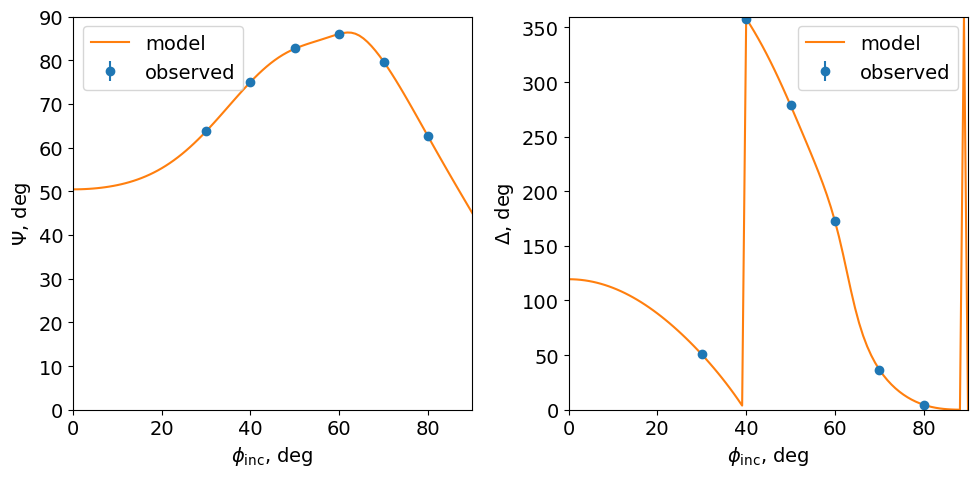

In [435]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [436]:
jac_res = jax.jacobian(residuals)(sol.value, args)

In [437]:
cov_matrix = jnp.linalg.inv(jac_res.T @ jac_res)

In [438]:
print(cov_matrix)

[[ 1.21734265e-01 -2.92640306e-04 -1.40925949e-02  2.89475976e-02]
 [-2.92640306e-04  7.64663098e-07 -9.68707130e-05 -9.59248825e-06]
 [-1.40925949e-02 -9.68707130e-05  3.44582549e-01 -1.64049187e-01]
 [ 2.89475976e-02 -9.59248825e-06 -1.64049187e-01  1.06837540e-01]]


In [439]:
std_params = jnp.sqrt(jnp.diag(cov_matrix))

In [440]:
sol.value, std_params

(Array([400.31578292,   1.46137279,   4.30238149,   5.26174869], dtype=float64),
 Array([0.34890438, 0.00087445, 0.58701154, 0.32686012], dtype=float64))

In [441]:
outer_v = np.outer(std_params, std_params)

In [442]:
cor_matrix = cov_matrix/outer_v

In [443]:
cor_matrix

Array([[ 1.        , -0.95916353, -0.06880784,  0.25383071],
       [-0.95916353,  1.        , -0.1887169 , -0.03356095],
       [-0.06880784, -0.1887169 ,  1.        , -0.8549988 ],
       [ 0.25383071, -0.03356095, -0.8549988 ,  1.        ]],      dtype=float64)